In [74]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from scipy.optimize import curve_fit
from scipy.stats import norm
import copy
import time

In [ ]:
def get_signal_vals(sigma_r, delta_x, A, B, lam, size=1):
    '''
    Generate signal values representing the response of a single pixel with RTN.
    
    Parameters:
    -----------
    sigma_r : float
        The read noise standard deviation, in electrons.
    delta_x : float
        The separation between the central Gaussian and the shifted Gaussians, in electrons.
    A : float
        The fraction of time the occupancy does not change between CDS samples.
    B : float
        The fraction of time the occupancy changes such that the signal is in the lower peak.
    lam : float
        The mean of the Poisson-distributed number of photoelectrons added to the signal.
    size : int
        The number of signal values to generate.
    '''
    if A + B > 1:
        raise ValueError("A + B must be less than or equal to 1.")
    signal_vals = np.zeros(size)
    # Generate random numbers from 0 to 1 to determine which bias peak to sample from
    bias_rand_vals = np.random.rand(size)
    # For elements of bias_rand_vals less than A, sample from central Gaussian
    first_peak_indices = np.where(bias_rand_vals < A)[0]
    signal_vals[first_peak_indices] = np.random.normal(loc=0, scale=sigma_r, size=len(first_peak_indices))
    # For elements between A and A+B, sample from first shifted Gaussian
    second_peak_indices = np.where((bias_rand_vals >= A) & (bias_rand_vals < A + B))[0]
    signal_vals[second_peak_indices] = np.random.normal(loc=delta_x, scale=sigma_r, size=len(second_peak_indices))
    # For elements greater than A+B, sample from second shifted Gaussian
    third_peak_indices = np.where(bias_rand_vals >= A + B)[0]
    signal_vals[third_peak_indices] = np.random.normal(loc=-delta_x, scale=sigma_r, size=len(third_peak_indices))
    # Add lam Poisson-distributed noise
    signal_vals += np.random.poisson(lam, size)
    return signal_vals, second_peak_indices, third_peak_indices

def get_digital_signal_vals(data, gain=1, bias_level=0):
    '''
    Convert analog signal values to digital by applying gain and bias level.
    Parameters:
    -----------
    data : np.ndarray
        The input analog signal values.
    gain : float
        The gain factor (ADU/e-).
    bias_level (float):
        The bias level to be added (in ADU).
    '''
    digital_data = data * gain + bias_level
    digital_data = np.round(digital_data).astype(int)
    return digital_data

def rtn_triple_gaussian(x, mu, A, B1, B2, d, sigma):
    # Model RTN pixel histogram as sum of three Gaussians.
    central_gaussian = A * np.exp(- (x - mu) ** 2 / (sigma) ** 2 / 2)
    left_gaussian = B1 * np.exp(- (x + d - mu) ** 2 / (sigma) ** 2 / 2)
    right_gaussian = B2 * np.exp(- (x - d - mu) ** 2 / (sigma) ** 2 / 2)
    return central_gaussian + left_gaussian + right_gaussian

# ZZZ haven't finished writing or testing this function
def fit_pixel_rtn(pixel_data, initial_guesses):
    # Fit the histogram of pixel data to the RTN triple Gaussian model.
    counts, bin_edges = np.histogram(pixel_data, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    p0 = initial_guesses
    try:
        popt, pcov = curve_fit(rtn_triple_gaussian, bin_centers, counts, p0=p0)
        mu_fit, A_fit, B1_fit, B2_fit, d_fit, sigma_fit = popt
        return mu_fit, A_fit, B1_fit, B2_fit, d_fit, sigma_fit
    except RuntimeError:
        raise RuntimeError("Fit did not converge")

In [116]:
sigma_r = 1
delta_x = 5
A = 0.7
B = 0.1
lam = 0
samples = 10000
gain = 42
bias_level = 1000
bin_size = 10

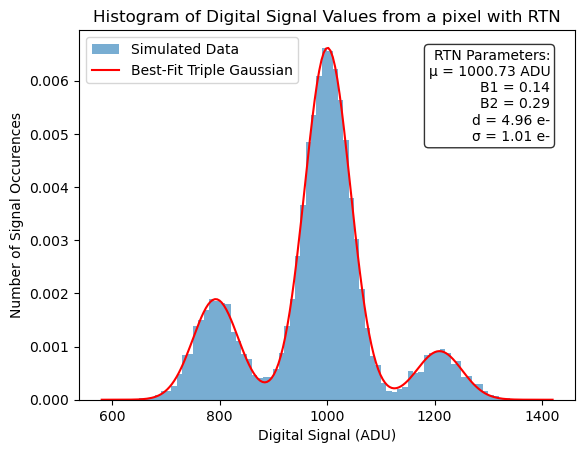

In [123]:
test_array = get_signal_vals(sigma_r=sigma_r, delta_x=delta_x, A=A, B=B, lam=lam, size=samples)[0]
digital_test_array = get_digital_signal_vals(test_array, gain=gain, bias_level=bias_level)
bins = np.arange(bias_level - 2 * delta_x * gain, bias_level + 2 * delta_x * gain + 1, bin_size)
plt.hist(digital_test_array, bins=bins, label='Simulated Data', alpha=0.6, density=True)
fit_params = fit_pixel_rtn(digital_test_array, initial_guesses=[bias_level, 0.6, 0.2, 0.2, delta_x * gain, sigma_r * gain])
B1 = fit_params[2] / fit_params[1]
B2 = fit_params[3] / fit_params[1]
x_fit = np.linspace(bias_level - 2 * delta_x * gain, bias_level + 2 * delta_x * gain, 200)
y_fit = rtn_triple_gaussian(x_fit, *fit_params)
plt.plot(x_fit, y_fit, 'r-', label='Best-Fit Triple Gaussian')
# Put fit parameters on plot
param_text = (f"RTN Parameters:\n"
              f"μ = {fit_params[0]:.2f} ADU\n"
              f"B1 = {B1:.2f}\n"
              f"B2 = {B2:.2f}\n"
              f"d = {fit_params[4] / gain:.2f} e-\n"
              f"σ = {fit_params[5] / gain:.2f} e-")
plt.text(0.95, 0.95, param_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.legend()
plt.xlabel('Digital Signal (ADU)')
plt.ylabel('Number of Signal Occurences')
plt.title('Histogram of Digital Signal Values from a pixel with RTN')
plt.show()

A few starting points for things to figure out:
- Roughly how many samples are needed to reliably parametrize the RTN response of a pixel?
- How much does how the data is binned affect the parametrization? What is the optimal bin size for a given data set?
- If the read noise and gain are close to 1, does fitting a triple Gaussian to a histogram still work, or does the digitization become a problem?
- Is it important to fit to a digitized triple Gaussian rather than a normal, continuous triple Gaussian?
- Speeding up the fits
    - How important are good initial guesses?
    - How do the times required to (a) perform a normality test on the data, (b) sort the values into histograms, and (c) fit the histograms depend on the number of samples?